# 数据聚合与分组运算

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#groupby()技术" data-toc-modified-id="groupby()技术-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>groupby()技术</a></span><ul class="toc-item"><li><span><a href="#GroupBy机制" data-toc-modified-id="GroupBy机制-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>GroupBy机制</a></span></li><li><span><a href="#对分组进行迭代" data-toc-modified-id="对分组进行迭代-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>对分组进行迭代</a></span><ul class="toc-item"><li><span><a href="#字典存储分组结果" data-toc-modified-id="字典存储分组结果-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>字典存储分组结果</a></span></li></ul></li><li><span><a href="#按列分组" data-toc-modified-id="按列分组-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>按列分组</a></span></li><li><span><a href="#选取一个或多个列" data-toc-modified-id="选取一个或多个列-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>选取一个或多个列</a></span></li><li><span><a href="#通过字典或者Series进行分组" data-toc-modified-id="通过字典或者Series进行分组-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>通过字典或者Series进行分组</a></span></li><li><span><a href="#通过函数进行分组" data-toc-modified-id="通过函数进行分组-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>通过函数进行分组</a></span></li><li><span><a href="#根据索引级别分组" data-toc-modified-id="根据索引级别分组-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>根据索引级别分组</a></span></li></ul></li><li><span><a href="#分组应用的一些整理" data-toc-modified-id="分组应用的一些整理-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>分组应用的一些整理</a></span></li><li><span><a href="#数据聚合" data-toc-modified-id="数据聚合-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>数据聚合</a></span></li></ul></div>

对数据集进行分组并对各组应用一个函数(无论聚合还是转换)，这是数据分析的重要工作。通常做法是计算分组或生成透视表，`pandas`提供高效灵活的`groupby`功能，更自然地处理切片、切块和摘要等工作。

通过`Python`和`pandas`的表达，我们可以使用pandas对象或NumPy数组执行相当复杂的操作，主要学习：
+ 使用一个或多个建(可以是函数、数组或DataFrame列名的形式)将pandas对象拆分成多块
+ 计算分组统计摘要，如计数、平均值、标准差或用户自定义函数
+ 应用组内转换或其他运算，如标准化、线性回归、排名或选取子集等
+ 计算`数据透视表`或`交叉表`
+ 执行分位数分析和其他统计组分析

## groupby()技术

### GroupBy机制

分组运算：split-apply-combine
1. 第一阶段，pandas对象(可以是Series,DataFrame)中的数据会根据提供的键拆分为多组。拆分操作是在对象的特定轴上执行的，DataFrame可以在axis=(0, 1)上进行分组。
2. 将一个函数应用在各个分组产生一个新值。
3. 将函数执行的结果合并成最终的结果。
---
分组键可以有多种形式：
+ 列表或数组，长度需与待分组的轴一致
+ DataFrame的列名值
+ 字典或Series，需与待分组的值与分组名一致
+ 函数：处理轴索引或索引中的各个标签

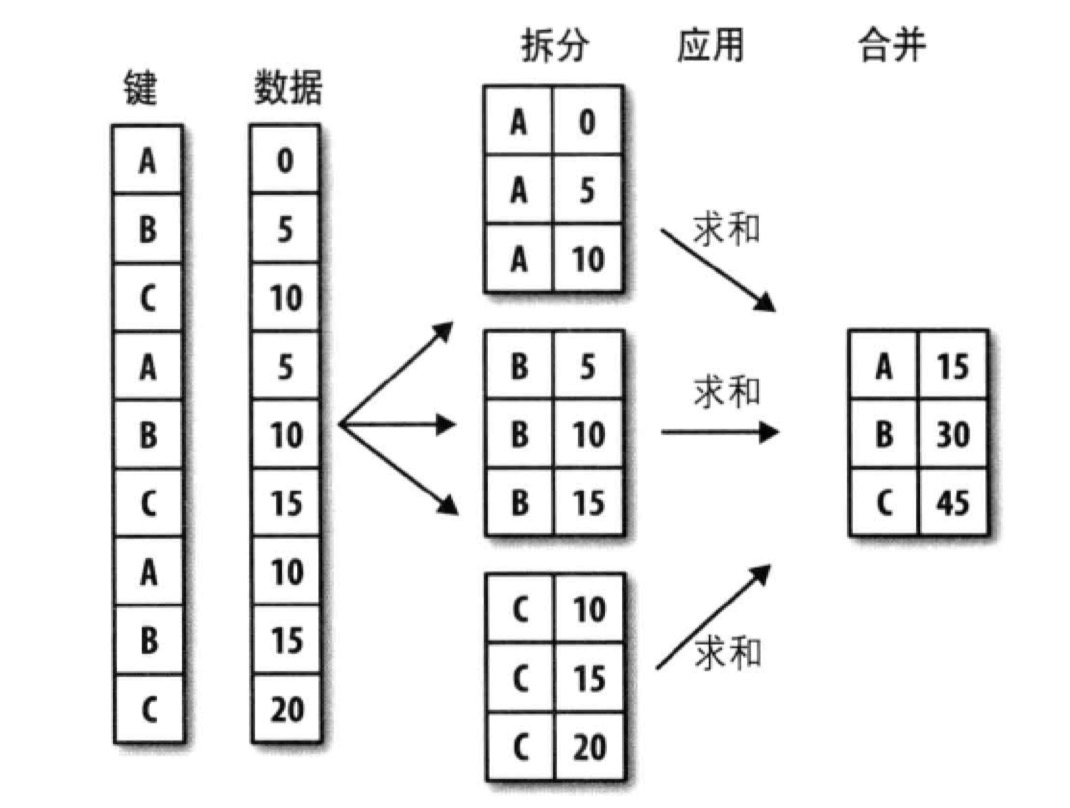

<span class="girk">后面三种分组键都只是一种快捷方式，最终目的都是产生一组用于拆分对象的值。</span>

+ 简单的数据框(DataFrame)类型示例：

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [2]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'],
                   'key2': ['one', 'two', 'one', 'two', 'one'],
                   'data1': np.random.randn(5),
                   'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,1.764052,-0.977278
1,a,two,0.400157,0.950088
2,b,one,0.978738,-0.151357
3,b,two,2.240893,-0.103219
4,a,one,1.867558,0.410599


使用key1作为分组键，对data1数据分组计算平均值：

In [3]:
grouped = df['data1'].groupby(df['key1'])
grouped

grouped的结果对应了split之后的分组结果，是计算平均值的中间量。

In [4]:
grouped.mean()

key1
a    1.343923
b    1.609816
Name: data1, dtype: float64

可以利用多组数据进行分组：

In [5]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     1.815805
      two     0.400157
b     one     0.978738
      two     2.240893
Name: data1, dtype: float64

得到的Series具有层次结构的索引：

In [6]:
means.unstack()

key2,one,two
key1,,
a,1.815805,0.400157
b,0.978738,2.240893


+ 分组键可以是尺寸适当的数组：

In [7]:
states = ['Ohio', 'California', 'California', 'Ohio', 'Ohio']
years = [2005, 2005, 2006, 2005, 2006]

In [8]:
df['data1'].groupby([states,years]).mean()

California  2005    0.400157
            2006    0.978738
Ohio        2005    2.002473
            2006    1.867558
Name: data1, dtype: float64

+ 比较常用的是直接使用列名作为分组键：

In [9]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   1.815805 -0.283340
     two   0.400157  0.950088
b    one   0.978738 -0.151357
     two   2.240893 -0.103219

In [10]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,1.343923,0.127803
b,1.609816,-0.127288


可以看到，key2列没有求均值，主要是因为key2列不是数值输数据（俗称麻烦列），<font color='orange'>默认情况下只有数值列会被聚合！</font>

### 对分组进行迭代

In [11]:
for name, group in df.groupby('key1'):
    print(name, '-'*10, sep='\n')
    print(group)

a
----------
  key1 key2     data1     data2
0    a  one  1.764052 -0.977278
1    a  two  0.400157  0.950088
4    a  one  1.867558  0.410599
b
----------
  key1 key2     data1     data2
2    b  one  0.978738 -0.151357
3    b  two  2.240893 -0.103219


In [12]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print('{}=={}'.format(k1, k2), '-'*10, sep='\n')
    print(group)

a==one
----------
  key1 key2     data1     data2
0    a  one  1.764052 -0.977278
4    a  one  1.867558  0.410599
a==two
----------
  key1 key2     data1     data2
1    a  two  0.400157  0.950088
b==one
----------
  key1 key2     data1     data2
2    b  one  0.978738 -0.151357
b==two
----------
  key1 key2     data1     data2
3    b  two  2.240893 -0.103219


#### 字典存储分组结果
不难看出分组之后的数据以类似字典的形式存储为可迭代的对象，所以我们可以将分组的结果作为字典：

In [7]:
pieces = dict(list(df.groupby('key1')))
pieces['a']

,key1,key2,data1,data2
0,a,one,1.764052,-0.977278
1,a,two,0.400157,0.950088
4,a,one,1.867558,0.410599


### 按列分组

In [8]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [9]:
grouped = df.groupby(df.dtypes, axis=1)
dict(list(grouped))

{dtype('float64'):       data1     data2
 0  1.764052 -0.977278
 1  0.400157  0.950088
 2  0.978738 -0.151357
 3  2.240893 -0.103219
 4  1.867558  0.410599, dtype('O'):   key1 key2
 0    a  one
 1    a  two
 2    b  one
 3    b  two
 4    a  one}

### 选取一个或多个列

+ 获取一个或多个列的分组的语法糖

In [11]:
df.groupby('key1')['data1'].mean()

key1
a    1.343923
b    1.609816
Name: data1, dtype: float64

In [12]:
df.groupby('key1')[['data1']].mean()

,data1
key1,
a,1.343923
b,1.609816


+ 等价表达：

In [13]:
df[['data1']].groupby(df['key1']).mean()

,data1
key1,
a,1.343923
b,1.609816


### 通过字典或者Series进行分组

In [16]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=list('abcde'),
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.loc['Wes', ['b', 'c']] = np.NaN     # 添加一些空值
people

,a,b,c,d,e
Joe,-0.672460,-0.359553,-0.813146,-1.726283,0.177426
Steve,-0.401781,-1.630198,0.462782,-0.907298,0.051945
Wes,0.729091,NaN,NaN,-1.234826,0.402342
Jim,-0.684810,-0.870797,-0.578850,-0.311553,0.056165
Travis,-1.165150,0.900826,0.465662,-1.536244,1.488252


假设已知分组列的对应关系，完成列的总计：

In [19]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue', 
           'd': 'blue', 'e': 'red', 'f': 'orange'}
people.groupby(mapping, axis=1).sum()

,blue,red
Joe,-2.539429,-0.854587
Steve,-0.444516,-1.980034
Wes,-1.234826,1.131432
Jim,-0.890402,-1.499442
Travis,-1.070581,1.223929


同样Series可以看出是一个固定的映射关系：

In [24]:
map_series = pd.Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [26]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


<div class="burk">
count()函数过滤掉了NaN的值！</div><i class="fa fa-lightbulb-o "></i>

### 通过函数进行分组

相比较于字典和Series，函数更加灵活与抽象，函数作用在需要分组的索引上，返回值作为分组的名称，看一个简单的示例：

In [27]:
people.groupby(len).sum()

,a,b,c,d,e
3,-0.628180,-1.230350,-1.391996,-3.272661,0.635933
5,-0.401781,-1.630198,0.462782,-0.907298,0.051945
6,-1.165150,0.900826,0.465662,-1.536244,1.488252


+ 函数与Series、list、dict可以混用，<span class="girk">因为最终都会转化为数组</span>：

In [28]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.672460 -0.359553 -0.813146 -1.726283  0.177426
  two -0.684810 -0.870797 -0.578850 -0.311553  0.056165
5 one -0.401781 -1.630198  0.462782 -0.907298  0.051945
6 two -1.165150  0.900826  0.465662 -1.536244  1.488252

### 根据索引级别分组

层次化数据集最方面的地方在于能够根据索引级别进行聚合。实现该功能只需通过`level`传入级别的编号或名称即可。

In [29]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'], 
                                     [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      1.895889  1.178780 -0.179925 -1.070753  1.054452
1     -0.403177  1.222445  0.208275  0.976639  0.356366
2      0.706573  0.010500  1.785870  0.126912  0.401989
3      1.883151 -1.347759 -1.270485  0.969397 -1.173123

In [33]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


In [34]:
hier_df.groupby(level=1, axis=1).count()

tenor,1,3,5
0,2,2,1
1,2,2,1
2,2,2,1
3,2,2,1


## 分组应用的一些整理

1. 分组之后的得到的SeriesGroupby或者DataFrameGroupby对象，可以迭代获取分组键及对应分组内容。
2. groupby中的常用操作：aggregate、filter、transform、apply（聚合，过滤，转换，应用）。

## 数据聚合

聚合：任何能够从数组中产生标量的数据转化过程。<br>
例如quantile()方法可以计算Series或DataFrame的百分位数：

In [35]:
df

,key1,key2,data1,data2
0,a,one,1.764052,-0.977278
1,a,two,0.400157,0.950088
2,b,one,0.978738,-0.151357
3,b,two,2.240893,-0.103219
4,a,one,1.867558,0.410599


In [37]:
df['data1'].groupby(df['key1']).quantile(0.9)

key1
a    1.846857
b    2.114678
Name: data1, dtype: float64

In [39]:
df.groupby('key1')['data1'].quantile(0.9)

key1
a    1.846857
b    2.114678
Name: data1, dtype: float64